## Part 1: Heterogenous treatment effects using causal trees and forests

1.1 Load the data

In [1]:
import pandas as pd 
import numpy as np

data = pd.read_csv('../data/experimental/experimental_control.csv')
data.head()

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78
0,1,37,11,1,0,1,1,0.0,0.0,9930.045898
1,1,22,9,0,1,0,1,0.0,0.0,3595.894043
2,1,30,12,1,0,0,0,0.0,0.0,24909.449219
3,1,27,11,1,0,0,1,0.0,0.0,7506.145996
4,1,33,8,1,0,0,1,0.0,0.0,289.789886


1.2 Find the ATE

In [2]:
import statsmodels.formula.api as smf

smf.ols('re78 ~ treat', data).fit().summary().tables[1]


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,4554.8011,408.046,11.162,0.000,3752.855,5356.747
treat,1794.3424,632.853,2.835,0.005,550.574,3038.110


Participation in the National Supported Work Demonstration Job Training Program increases real earnings by $1 794 on average.

1.3 Heterogenous effects with causal trees

In [3]:
X = [x for x in data.columns if x != 're78' and x !='treat']

In [4]:
from econml.dml import CausalForestDML

tree_model = CausalForestDML(n_estimators=1, subforest_size=1, inference=False, max_depth=3, random_state = 123)
tree_model = tree_model.fit(Y=data['re78'], X=data[X], T=data['treat'])

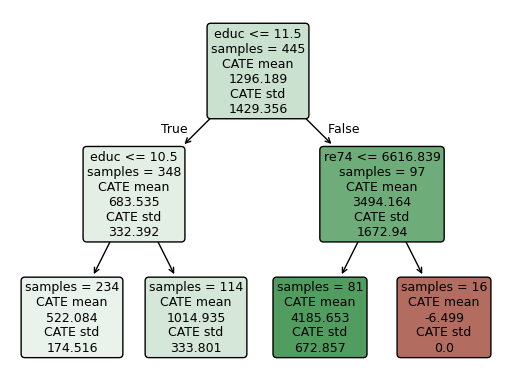

In [5]:
import matplotlib.pyplot as plt
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(tree_model, data[X])
intrp.plot(feature_names=X)
plt.show()

The interpretation is subject to the depth your tree ends up with. As specified in the issue, we would stick to what we saw in class (that is, an arbitrarily small tree). However, do not forget that a proper way to tune hyperparameters is Cross-Validation. 

In our case, the treatment is more effective on individuals with more than 11.5 years of education and income of $6 617 or less. For those individuals, the treatment increases their real earnings by $4 186 on average.

1.4 Heterogenous effects with causal forests

In [6]:
forest_model = CausalForestDML(max_depth=3, random_state = 123)
forest_model = forest_model.fit(Y=data['re78'], X=data[X], T=data['treat'])

In [7]:
feature_imp = pd.DataFrame(
    {'importance':forest_model.feature_importances_},
    index=X)
feature_imp.sort_values(by='importance', ascending=False)

,importance
age,0.283512
educ,0.222320
re74,0.202884
re75,0.144400
black,0.087653
marr,0.026820
hisp,0.020174
nodegree,0.012237


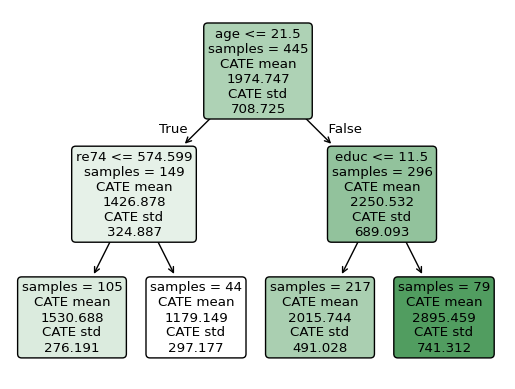

In [8]:
import matplotlib.pyplot as plt
from econml.cate_interpreter import SingleTreeCateInterpreter
%matplotlib inline

intrp = SingleTreeCateInterpreter(max_depth=2).interpret(forest_model, data[X])
intrp.plot(feature_names=X)
plt.show()

1.5 Plot heterogenous effects

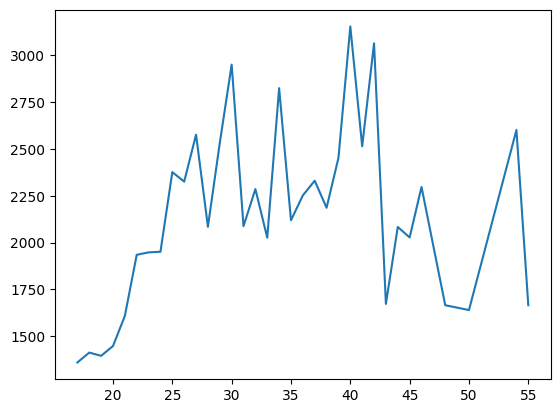

In [9]:
data["predicted_effect"] = forest_model.effect(data[X])
predicted_effect_bins = data.groupby("age")["predicted_effect"].mean()
plt.plot(predicted_effect_bins.index, predicted_effect_bins.values)

plt.show()

## Part 2: Double/Debiased machine learning in obsevational data

2.1 Load the data

In [10]:
data = pd.read_csv('../data/observational/biased_control.csv')
data.head()

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,agesq,agecube,educsq,u74,u75,interaction1,re74sq,re75sq
0,0,45,11,0,0,1,1,21.516670,25.243551,25.564670,2025,91125,121,0,0,236.683369,462.967085,637.236856
1,0,21,14,0,0,0,0,3.175971,5.852565,13.496080,441,9261,196,0,0,44.463593,10.086791,34.252516
2,0,38,12,0,0,1,0,23.039020,25.130760,25.564670,1444,54872,144,0,0,276.468234,530.796421,631.555086
3,0,48,6,0,0,1,1,24.994369,25.243551,25.564670,2304,110592,36,0,0,149.966215,624.718489,637.236856
4,0,18,8,0,0,1,1,1.669295,10.727610,9.860869,324,5832,64,0,0,13.354360,2.786546,115.081624


2.2 Group comparisons

In [11]:
control = data[data['treat']==0]
treated = data[data['treat']==1]

In [12]:
control.describe()

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,agesq,agecube,educsq,u74,u75,interaction1,re74sq,re75sq
count,15992.0,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000,15992.000000
mean,0.0,33.225238,12.027514,0.073537,0.072036,0.711731,0.295835,14.016800,13.650804,14.846660,1225.905578,49305.853302,152.902326,0.119622,0.109305,171.147640,288.045960,272.279442
std,0.0,11.045216,2.870846,0.261024,0.258556,0.452971,0.456432,9.569796,9.270403,9.647392,784.738239,45139.009906,67.166329,0.324530,0.312031,129.218820,260.276050,246.906693
min,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,256.000000,4096.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,24.000000,11.000000,0.000000,0.000000,0.000000,0.000000,4.403452,4.398823,5.669298,576.000000,13824.000000,121.000000,0.000000,0.000000,46.875448,19.390396,19.349646
50%,0.0,31.000000,12.000000,0.000000,0.000000,1.000000,0.000000,15.123580,14.557110,16.421975,961.000000,29791.000000,144.000000,0.000000,0.000000,166.861978,228.722690,211.909462
75%,0.0,42.000000,13.000000,0.000000,0.000000,1.000000,1.000000,23.584180,22.923737,25.564670,1764.000000,74088.000000,169.000000,0.000000,0.000000,284.485523,556.213532,525.497710
max,0.0,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,25.862320,25.243551,25.564670,3025.000000,166375.000000,324.000000,1.000000,1.000000,465.521766,668.859612,637.236856


In [13]:
treated.describe()

,treat,age,educ,black,hisp,marr,nodegree,re74,re75,re78,agesq,agecube,educsq,u74,u75,interaction1,re74sq,re75sq
count,185.0,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000,185.000000
mean,1.0,25.816216,10.345946,0.843243,0.059459,0.189189,0.708108,2.095574,1.532055,6.349144,717.394595,21554.659459,111.059459,0.708108,0.600000,22.898726,28.141412,12.654750
std,0.0,7.155019,2.010650,0.364558,0.237124,0.392722,0.455867,4.886620,3.219251,7.867402,431.251706,20964.707513,39.303885,0.455867,0.491227,57.393970,114.103274,56.033667
min,1.0,17.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,289.000000,4913.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,20.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.485230,400.000000,8000.000000,81.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,25.000000,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,4.232309,625.000000,15625.000000,121.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.0,29.000000,12.000000,1.000000,0.000000,0.000000,1.000000,1.291468,1.817284,9.642999,841.000000,24389.000000,144.000000,1.000000,1.000000,12.914680,1.667890,3.302521
max,1.0,48.000000,16.000000,1.000000,1.000000,1.000000,1.000000,35.040070,25.142240,60.307930,2304.000000,110592.000000,256.000000,1.000000,1.000000,490.560984,1227.806528,632.132244


The first thing to notice in the observational dataset is that the treated are significantly less than the controls. Among the features, age shows a clear difference of nearly 10 years on average between groups. The same can be said from de real income, with an average difference between groups of around $8 000 dollars. And so on.

As stated in the issue, the treatment and the control groups are not comparable. Therefore, these differences may be significant.

2.3 Compute the SMD

In [14]:
smf.ols('re78 ~ treat', data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,14.8467,0.076,194.984,0.000,14.697,14.996
treat,-8.4975,0.712,-11.934,0.000,-9.893,-7.102


Unlike the controlled experiment, this result tells us that participation in the National Supported Work Demonstration Job Training Program reduces real earnings by $8 498 on average; this shows the clear bias due to the lack of a proper control group. 

2.4 Using DML

In [15]:
X = [x for x in data.columns if x != 're78' and x !='treat']

DoubleML is an easy to use tool for DML. It's usage is pretty straight-forward and can be easily implemented by reading the [documentation](https://docs.doubleml.org/stable/intro/intro.html)

In [16]:
# pip install -U DoubleML
from doubleml import DoubleMLData

dml_data = DoubleMLData(data, y_col= 're78', d_cols= 'treat', x_cols= X)
print(dml_data)

================== DoubleMLData Object ==================

------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): ['treat']
Covariates: ['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're74', 're75', 'agesq', 'agecube', 'educsq', 'u74', 'u75', 'interaction1', 're74sq', 're75sq']
Instrument variable(s): None
No. Observations: 16177

------------------ DataFrame info    ------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16177 entries, 0 to 16176
Columns: 18 entries, treat to re75sq
dtypes: float64(6), int64(12)
memory usage: 2.2 MB



We will implement the learners saw in class: OLS, Lasso, Random trees and Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LassoCV
import warnings
warnings.filterwarnings("ignore")

In [41]:
l_OLS = LinearRegression()
l_lasso = LassoCV()
l_RT = RandomForestRegressor(n_estimators=1)
l_RF = RandomForestRegressor(n_estimators=200)


In [42]:
from doubleml import DoubleMLPLR

np.random.seed(123)

DML_ols = DoubleMLPLR(dml_data, l_OLS, l_OLS).fit()

In [43]:
DML_lasso = DoubleMLPLR(dml_data, l_lasso, l_lasso).fit()

In [36]:
DML_RT = DoubleMLPLR(dml_data, l_RT, l_RT).fit()

In [22]:
DML_RF = DoubleMLPLR(dml_data, l_RF, l_RF).fit()

In [117]:
print(DML_ols)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): ['treat']
Covariates: ['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're74', 're75', 'agesq', 'agecube', 'educsq', 'u74', 'u75', 'interaction1', 're74sq', 're75sq']
Instrument variable(s): None
No. Observations: 16177

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: LinearRegression()
Learner ml_m: LinearRegression()
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[6.98706878]]
Learner ml_m RMSE: [[0.09866969]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
           coef   std err         t     P>|t|     2.5 %    97.5 %
treat  1.596156  0.629581  2.535265  0.011236  0.362199  2.830112


In [118]:
print(DML_lasso)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): ['treat']
Covariates: ['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're74', 're75', 'agesq', 'agecube', 'educsq', 'u74', 'u75', 'interaction1', 're74sq', 're75sq']
Instrument variable(s): None
No. Observations: 16177

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: LassoCV()
Learner ml_m: LassoCV()
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[7.21739293]]
Learner ml_m RMSE: [[0.10633536]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
           coef  std err         t     P>|t|     2.5 %    97.5 %
treat -2.065467  0.57813 -3.572667  0.000353 -3.198582 -0.932353


In [119]:
print(DML_RT)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): ['treat']
Covariates: ['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're74', 're75', 'agesq', 'agecube', 'educsq', 'u74', 'u75', 'interaction1', 're74sq', 're75sq']
Instrument variable(s): None
No. Observations: 16177

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(n_estimators=1)
Learner ml_m: RandomForestRegressor(n_estimators=1)
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[9.72611762]]
Learner ml_m RMSE: [[0.11975365]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
         coef   std err         t     P>|t|     2.5 %    97.5 %
treat  0.7342  0.639295  1.148452  0.2

In [120]:
print(DML_RF)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): ['treat']
Covariates: ['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're74', 're75', 'agesq', 'agecube', 'educsq', 'u74', 'u75', 'interaction1', 're74sq', 're75sq']
Instrument variable(s): None
No. Observations: 16177

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: RandomForestRegressor(n_estimators=200)
Learner ml_m: RandomForestRegressor(n_estimators=200)
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[7.36448147]]
Learner ml_m RMSE: [[0.09016356]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
           coef   std err        t    P>|t|     2.5 %   97.5 %
treat  1.097812  0.622674  1.76306 

Now, with the selected models based on minimum RMSE

In [123]:
DML_opt = DoubleMLPLR(dml_data, l_OLS, l_RF).fit()

In [124]:
print(DML_opt)

================== DoubleMLPLR Object ==================

------------------ Data summary      ------------------
Outcome variable: re78
Treatment variable(s): ['treat']
Covariates: ['age', 'educ', 'black', 'hisp', 'marr', 'nodegree', 're74', 're75', 'agesq', 'agecube', 'educsq', 'u74', 'u75', 'interaction1', 're74sq', 're75sq']
Instrument variable(s): None
No. Observations: 16177

------------------ Score & algorithm ------------------
Score function: partialling out

------------------ Machine learner   ------------------
Learner ml_l: LinearRegression()
Learner ml_m: RandomForestRegressor(n_estimators=200)
Out-of-sample Performance:
Regression:
Learner ml_l RMSE: [[6.98623302]]
Learner ml_m RMSE: [[0.08871243]]

------------------ Resampling        ------------------
No. folds: 5
No. repeated sample splits: 1

------------------ Fit summary       ------------------
           coef   std err         t    P>|t|     2.5 %    97.5 %
treat  0.622134  0.582558  1.067934  0.28555 -0.519659